In [1]:
from dataclasses import replace
from matplotlib import pyplot as plt
from pulser.devices import Chadoq2, AnalogDevice
from pulser.channels.dmm import DMM
from pulser.register import Register
from pulser.register.register_layout import RegisterLayout
from pulser.register.mappable_reg import MappableRegister
from pulser.register.weight_maps import DetuningMap
from pulser_simulation import QutipEmulator
from pulser.waveforms import InterpolatedWaveform
from pulser.sampler import sampler
from pulser.sequence import Sequence
from pulser.pulse import Pulse
from pulser.waveforms import ConstantWaveform, RampWaveform
import numpy as np

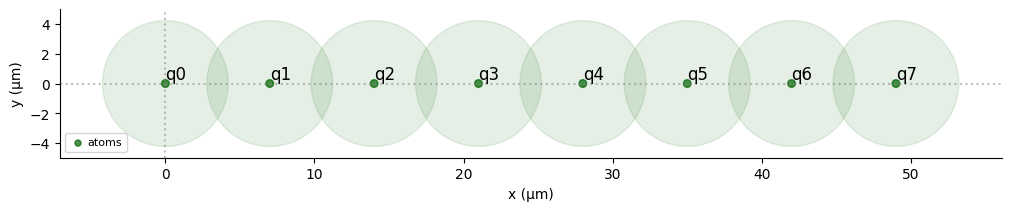

In [2]:
N = 8
L = 7.0
omega_max = 15

trap_coordinates = [(i*L,0.0) for i in range(N)]
weights = np.ones((N))

register = Register.from_coordinates(trap_coordinates, center=False, prefix="q")
register.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(omega_max),
    draw_graph=False,
    draw_half_radius=True,
)

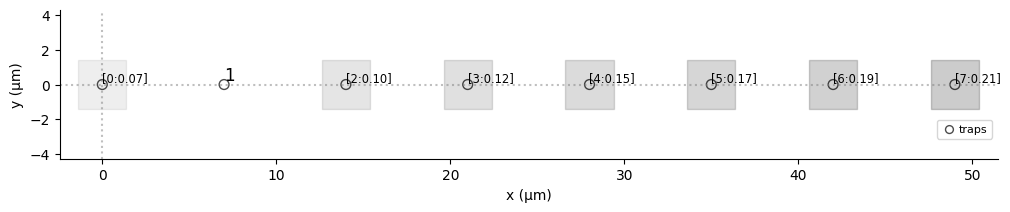

In [3]:
weights = np.array([0.325, 0] + list(np.linspace(0.5, 1, N-2)))
weights /= weights.sum()

dmm = DMM(
    clock_period=4,
    min_duration=16,
    max_duration=2**26,
    mod_bandwidth=8,
    bottom_detuning=-800,  # detuning between 0 and -20 rad/µs
)
Chadoq3 = replace(
    Chadoq2.to_virtual(),
    dmm_objects=(dmm, DMM()),
    reusable_channels=True,
    max_radial_distance=100,
    rydberg_level = 70,
    max_atom_num = 100
)

register_layout = RegisterLayout(trap_coordinates)
detuning_map = register_layout.define_detuning_map(
    {i: weights[i] for i in range(N)}  # mapping between trap ids and weights
)
detuning_map.draw(labels=range(N))

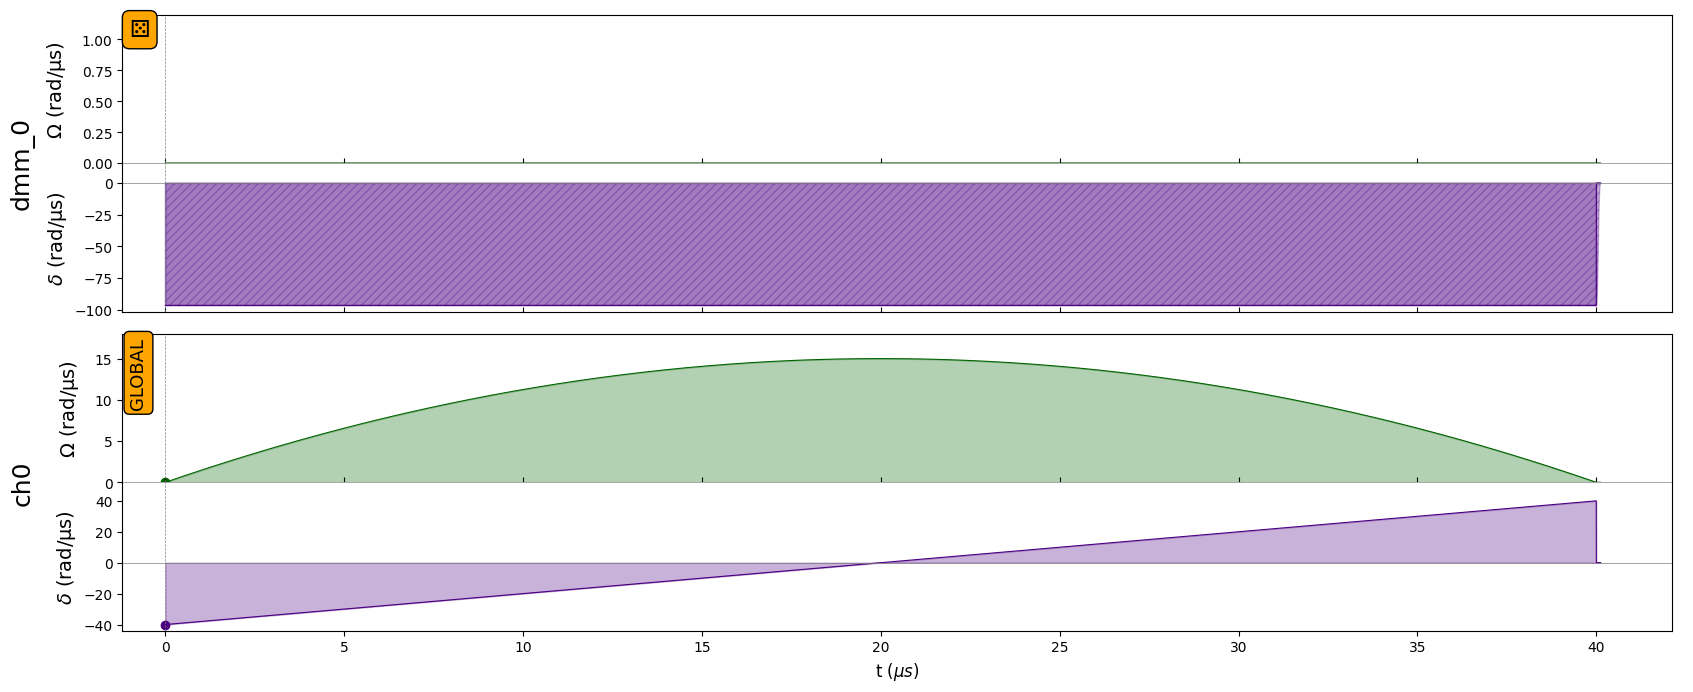

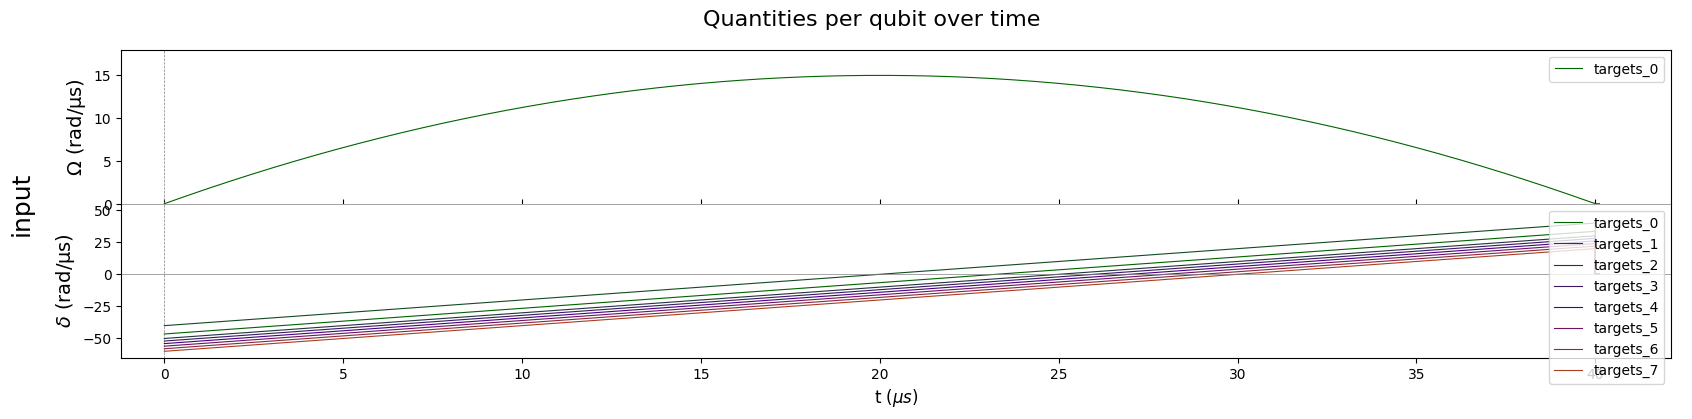

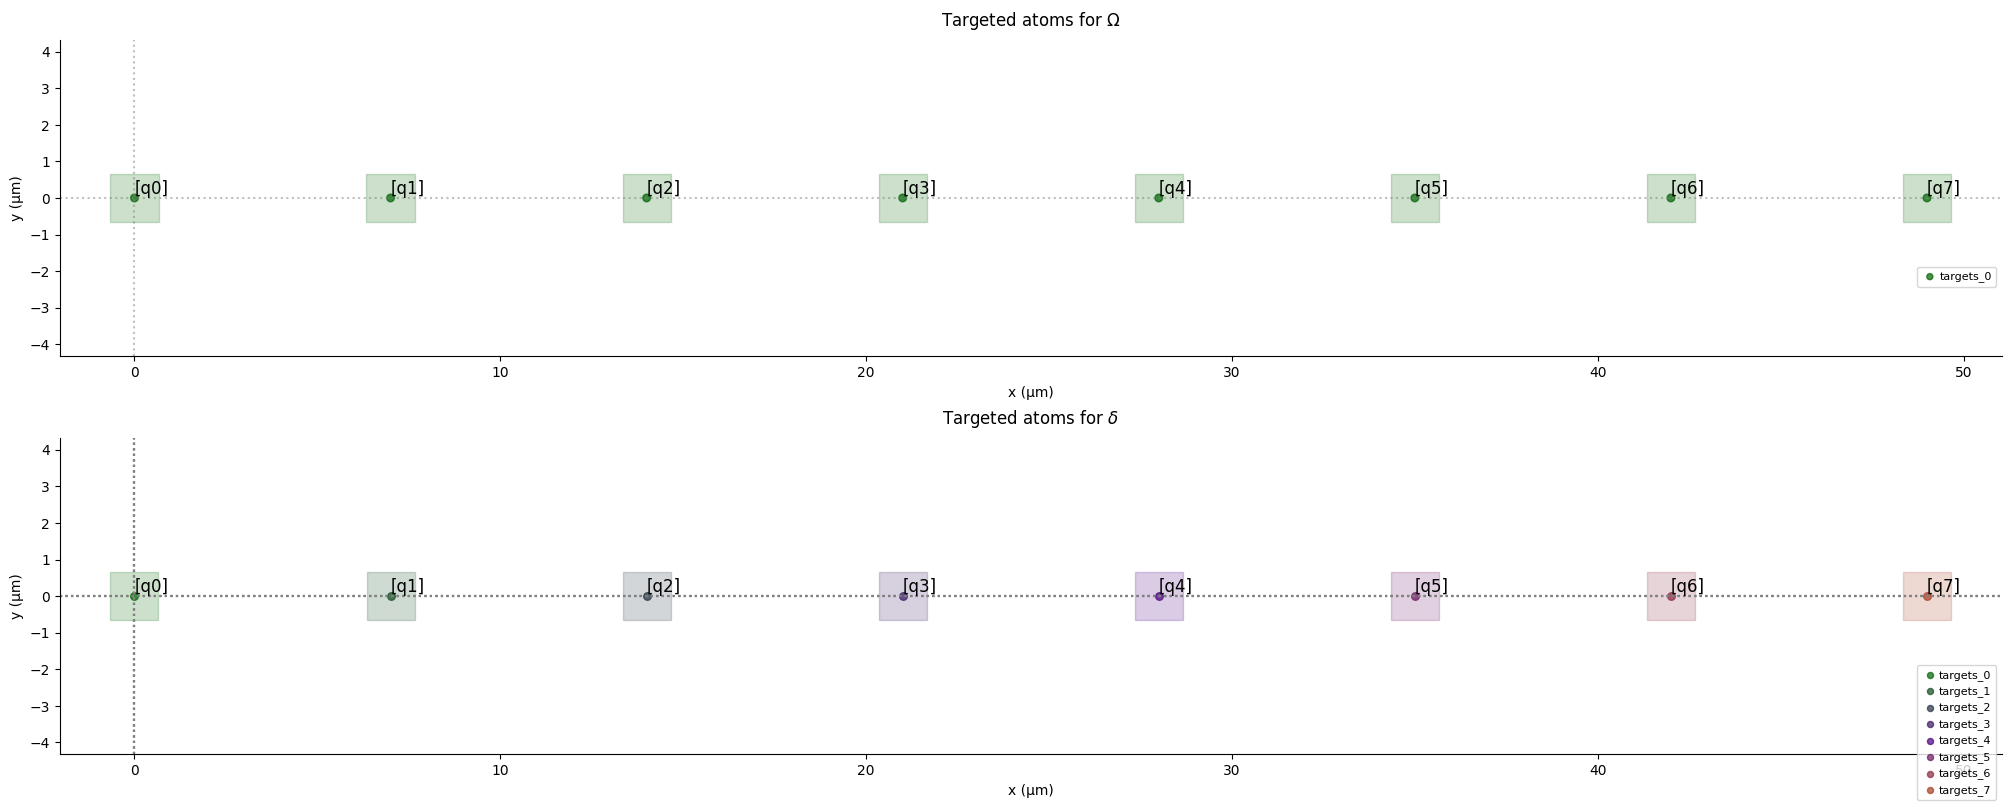

In [4]:
delta_abs = 40
T = 40000 # in ns, time of the signal

seq = Sequence(register, Chadoq3)

seq.config_detuning_map(detuning_map, "dmm_0")
seq.declare_channel("ch0", "rydberg_global")

adiabatic_pulse = Pulse(
    amplitude = InterpolatedWaveform(T, [1e-9, omega_max, 1e-9]), # By default, interpolate just connects the dots with cubic functions
    detuning = InterpolatedWaveform(T, [-delta_abs, delta_abs]),
    phase = 0
)

seq.add(adiabatic_pulse, "ch0")
seq.add_dmm_detuning(ConstantWaveform(T, -delta_abs / 2 / weights.max()), "dmm_0")
seq.draw(
        mode="input+output",
        draw_qubit_det=True,
         draw_qubit_amp=True)

In [5]:
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

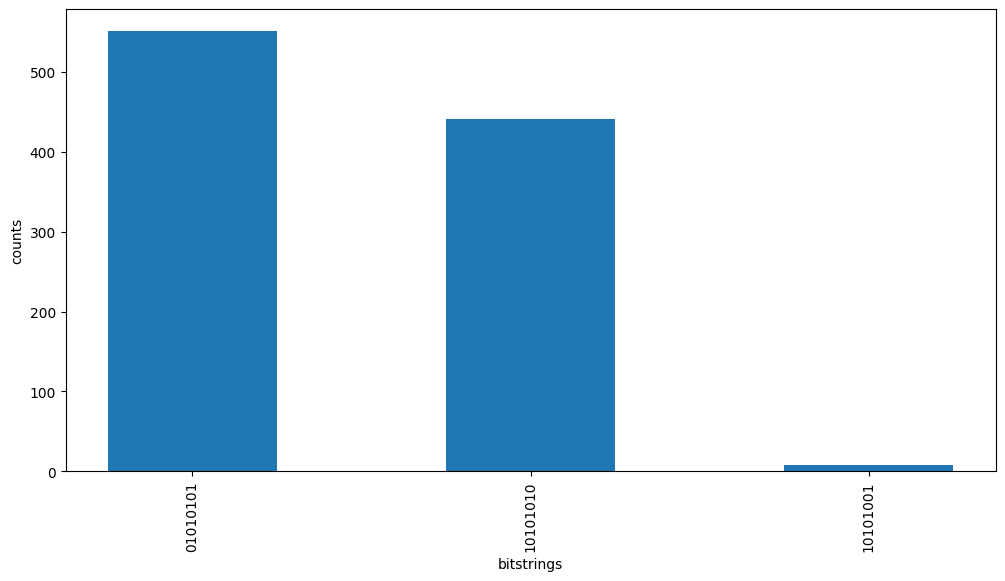

In [6]:
count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(12, 6))
plt.xlabel("bitstrings")
plt.ylabel("counts")
plt.bar(count_dict.keys(), count_dict.values(), width=0.5)
plt.xticks(rotation="vertical")
plt.show()

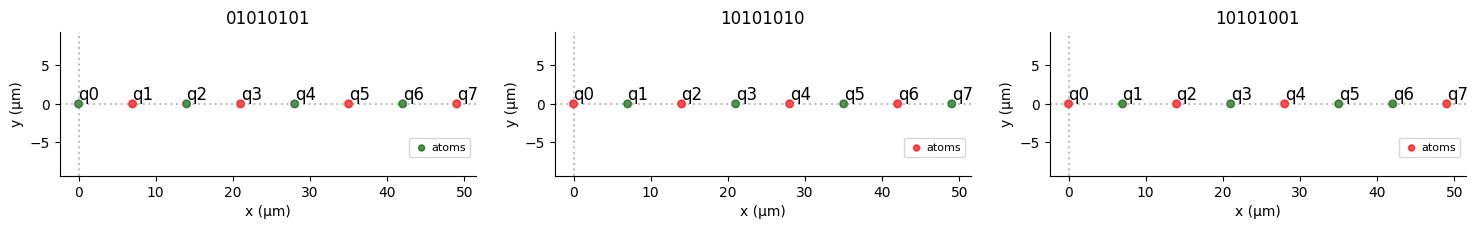

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(15, 6))
ax = ax.ravel()

for i in range(min(len(ax), len(count_dict))):
    m = list(count_dict.keys())[i]
    register.draw(
        qubit_colors={f"q{k}": "red" for k in range(len(m)) if m[k] == '1'},
        show = False,
        custom_ax=ax[i]
    )
    ax[i].set_title(m)
for i in range(len(count_dict), len(ax)):
    ax[i].set_visible(False)

plt.tight_layout()
plt.show()